In [1]:
# Install necessary libraries for the project using pip
# These libraries will help with tasks such as text processing, data manipulation, machine learning, and visualization

!pip install praw      
# Python Reddit API Wrapper - to interact with Reddit data
!pip install pandas   
# Data manipulation and analysis library - for handling structured data
!pip install nltk     
# Natural Language Toolkit - for processing and analyzing human language data
!pip install scikit-learn  
# Machine learning library - provides tools for classification, regression, etc.
!pip install textblob  
# Text processing library - useful for tasks like sentiment analysis and text classification
!pip install matplotlib  
# Plotting library - for data visualization and graphical representation
!pip install joblib   
# Used for serializing and deserializing Python objects, especially large objects like ML models


In [2]:
# Import necessary libraries for text processing, machine learning, and data analysis

import praw                          # Python Reddit API Wrapper - to interact with Reddit data and retrieve posts
import pandas as pd                  # pandas - for handling and analyzing structured data (DataFrames)
import re                             # Regular expression library - for text pattern matching and manipulation
from nltk.corpus import stopwords    # stopwords - a list of common words that are often removed in NLP tasks
from nltk.tokenize import word_tokenize  # word_tokenize - to split text into words/tokens for further processing
from nltk import download            # nltk.download - to download necessary datasets like stopwords
from textblob import TextBlob        # TextBlob - for simple text processing and sentiment analysis
from sklearn.model_selection import train_test_split  # train_test_split - to split dataset into training and testing sets
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier - machine learning algorithm for classification
from sklearn.metrics import accuracy_score, classification_report  # Metrics - to evaluate the performance of a model
import matplotlib.pyplot as plt      # matplotlib - for visualizations, such as charts and graphs
import joblib                        # joblib - for saving and loading machine learning models


In [3]:
# Download necessary NLTK resources for text processing
download('stopwords')  # Download the 'stopwords' dataset, which contains common stopwords in multiple languages
download('punkt')      # Download the 'punkt' tokenizer models for word tokenization (splitting text into words)
download('punkt_tab')  # Also try downloading punkt_tab explicitly


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
from dotenv import load_dotenv
import os
# Load environment variables from the .env file
# This function reads the .env file and loads the environment variables into the program.
load_dotenv()
# Retrieve the values from environment variables
client_id = os.getenv('client_id')            # Reddit API client ID loaded from the .env file
client_secret = os.getenv('client_secret')    # Reddit API client secret loaded from the .env file
user_agent = os.getenv('user_agent')          # Reddit API user agent loaded from the .env file
# Initialize Reddit API client using PRAW (Python Reddit API Wrapper)
# The Reddit API client is initialized with the credentials obtained from the environment variables.
reddit = praw.Reddit(
    client_id=client_id,         # Your unique client ID from the .env file
    client_secret=client_secret, # Your unique client secret from the .env file
    user_agent=user_agent       # A string identifying the user or application, passed from the .env file
)

In [5]:
# Function to scrape data from a subreddit with more extensive fetching

def fetch_reddit_data(subreddit_name, limit=5000):
    """
    Fetches posts from a Reddit subreddit with up to 'limit' number of posts.
    The function first tries to fetch posts from the 'hot' section, then from the 'new' section, 
    and finally from the 'top' section, ensuring that the total number of posts is equal to the limit.

    Parameters:
    subreddit_name (str): The name of the subreddit to scrape (e.g., 'stocks').
    limit (int): The maximum number of posts to retrieve. Default is 5000.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the scraped data (Title, Selftext, Upvotes, Comments).
    """
    subreddit = reddit.subreddit(subreddit_name)  # Access the subreddit using PRAW
    posts = []  # List to hold the scraped posts
    count = 0  # Counter to track the number of posts fetched

    # Loop through 'hot' posts, fetching as many as possible (up to 'limit')
    for submission in subreddit.hot(limit=limit):  # Start with 'hot' posts
        posts.append({
            'Title': submission.title,
            'Selftext': submission.selftext,
            'Upvotes': submission.ups,
            'Comments': submission.num_comments
        })
        count += 1  # Increment count
        if count >= limit:  # Stop if the desired limit is reached
            break

    # If fewer posts are fetched, move to 'new' posts
    if count < limit:
        for submission in subreddit.new(limit=limit - count):  # Fetch 'new' posts
            posts.append({
                'Title': submission.title,
                'Selftext': submission.selftext,
                'Upvotes': submission.ups,
                'Comments': submission.num_comments
            })
            count += 1
            if count >= limit:
                break  # Stop once the limit is reached

    # If still fewer posts are fetched, move to 'top' posts
    if count < limit:
        for submission in subreddit.top(limit=limit - count):  # Fetch 'top' posts
            posts.append({
                'Title': submission.title,
                'Selftext': submission.selftext,
                'Upvotes': submission.ups,
                'Comments': submission.num_comments
            })
            count += 1
            if count >= limit:
                break  # Stop once the limit is reached

    # Convert the list of posts into a pandas DataFrame and return it
    return pd.DataFrame(posts)

# Example: Fetch data from r/stocks with a larger limit (e.g., 5000 posts)
reddit_data = fetch_reddit_data('stocks', limit=5000)
print(f"Scraped {len(reddit_data)} posts from r/stocks.")  # Print how many posts were fetched
print(reddit_data.head())  # Display the first few rows of the scraped data


Scraped 1997 posts from r/stocks.
                                               Title  \
0  r/Stocks Daily Discussion & Fundamentals Frida...   
1  r/Stocks Daily Discussion & Technicals Tuesday...   
2  Intel down on great news and the bleeding cont...   
3                          How we feeling about RKLB   
4                                  RDDT Q4 prognosis   

                                            Selftext  Upvotes  Comments  
0  This is the daily discussion, so anything stoc...       25       465  
1  This is the daily discussion, so anything stoc...       12       232  
2  What am I missing? Intel receives 7 billion in...      215       166  
3  Pretty significant climb over the last few wee...      183       168  
4  Q3 was a big surprise due to DAU skyrocketing ...       45        64  


In [6]:
# Function to clean text data by removing URLs, special characters, and stopwords
def clean_text(text):
    """
    Cleans the input text by performing the following steps:
    1. Remove URLs.
    2. Remove special characters (keeping only alphanumeric characters and spaces).
    3. Convert text to lowercase.
    4. Tokenize the text into individual words.
    5. Remove common stopwords (e.g., 'the', 'and', 'is').
    Parameters:
    text (str): The raw text string to be cleaned.
    Returns:
    str: The cleaned text, with stopwords removed and text normalized.
    """
    # Remove URLs from the text using regular expressions
    text = re.sub(r'http\S+', '', text)  # Remove any string starting with 'http' or 'https'
    # Remove special characters (non-alphanumeric characters, except for spaces)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove characters that are not letters, numbers, or spaces
    # Convert all text to lowercase for uniformity
    text = text.lower()
    # Tokenize the text (split the text into individual words)
    tokens = word_tokenize(text)
    # Remove stopwords (common words that don't contribute much to meaning)
    text = ' '.join([word for word in tokens if word not in stopwords.words('english')])
    return text

In [7]:
# Clean the scraped data by applying the clean_text function to the 'Title' and 'Selftext' columns
reddit_data['Cleaned_Title'] = reddit_data['Title'].apply(clean_text)  # Apply text cleaning to post titles
reddit_data['Cleaned_Selftext'] = reddit_data['Selftext'].apply(clean_text)  # Apply text cleaning to selftext (post content)
# Function for sentiment analysis using TextBlob
def get_sentiment(text):
    """
    Analyzes the sentiment of a given text using the TextBlob library.
    It returns the sentiment polarity, where:
    - Polarity value ranges from -1 (very negative) to 1 (very positive).
    - A polarity of 0 indicates neutral sentiment.
    Parameters:
    text (str): The input text string whose sentiment is to be analyzed.
    Returns:
    float: The sentiment polarity of the input text.
    """
    analysis = TextBlob(text)  # Create a TextBlob object for sentiment analysis
    return analysis.sentiment.polarity  # Return the polarity value (ranging from -1 to 1)

In [8]:
# Perform sentiment analysis on the cleaned text data (Title and Selftext)
reddit_data['Title_Sentiment'] = reddit_data['Cleaned_Title'].apply(get_sentiment)  # Apply sentiment analysis to the 'Cleaned_Title' column
reddit_data['Selftext_Sentiment'] = reddit_data['Cleaned_Selftext'].apply(get_sentiment)  # Apply sentiment analysis to the 'Cleaned_Selftext' column
# Combine sentiment scores to compute the overall sentiment for each post
reddit_data['Overall_Sentiment'] = (reddit_data['Title_Sentiment'] + reddit_data['Selftext_Sentiment']) / 2  # Average of Title and Selftext sentiment scores
# Display the first few rows of the processed data to inspect the results
print(reddit_data.head())  # Output the first 5 rows of the DataFrame for inspection

                                               Title  \
0  r/Stocks Daily Discussion & Fundamentals Frida...   
1  r/Stocks Daily Discussion & Technicals Tuesday...   
2  Intel down on great news and the bleeding cont...   
3                          How we feeling about RKLB   
4                                  RDDT Q4 prognosis   

                                            Selftext  Upvotes  Comments  \
0  This is the daily discussion, so anything stoc...       25       465   
1  This is the daily discussion, so anything stoc...       12       232   
2  What am I missing? Intel receives 7 billion in...      215       166   
3  Pretty significant climb over the last few wee...      183       168   
4  Q3 was a big surprise due to DAU skyrocketing ...       45        64   

                                       Cleaned_Title  \
0  rstocks daily discussion fundamentals friday n...   
1  rstocks daily discussion technicals tuesday no...   
2                intel great news bleeding c

In [9]:
# Feature engineering: Create a subset of features for model training
# Create a copy of the relevant features ('Upvotes', 'Comments', 'Overall_Sentiment') to avoid modifying the original DataFrame
features = reddit_data[['Upvotes', 'Comments', 'Overall_Sentiment']].copy()  
# Simulate labels based on sentiment threshold:
# - Stock rise (1) if the overall sentiment is positive (> 0)
# - Stock drop (0) if the overall sentiment is neutral or negative (<= 0)
reddit_data['Stock_Rise'] = reddit_data['Overall_Sentiment'].apply(lambda x: 1 if x > 0 else 0)
# Combine features and labels in a new DataFrame using .loc to ensure correct indexing
features.loc[:, 'Stock_Rise'] = reddit_data['Stock_Rise']
# Prepare features (X) and labels (y) for machine learning
X = features[['Upvotes', 'Comments', 'Overall_Sentiment']]  # Features to predict stock rise or drop
y = features['Stock_Rise']  # Labels (1 for stock rise, 0 for stock drop)

In [10]:
# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a Random Forest Classifier on the training data
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize the Random Forest model with 100 trees
model.fit(X_train, y_train)  # Train the model on the training data

RandomForestClassifier(random_state=42)

In [11]:
# Predictions and evaluation: Make predictions on the test set and evaluate model performance
# Make predictions on the test set
y_pred = model.predict(X_test)  # Predict stock rise or drop for the test data
# Print the accuracy of the model
print("Accuracy:", accuracy_score(y_test, y_pred))  # Calculate and print the accuracy score
# Print the classification report to evaluate precision, recall, and F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Detailed performance metrics
# Save processed data and trained model
# Save the processed DataFrame (including features and labels) to a CSV file
reddit_data.to_csv('reddit_stock_analysis_large.csv', index=False)  # Save as a CSV file, excluding the index
# Save the trained model to a file using joblib for later use
joblib.dump(model, 'reddit_sentiment_model_large.pkl')  # Save the model in pickle format

Accuracy: 0.9975

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        94
           1       1.00      1.00      1.00       306

    accuracy                           1.00       400
   macro avg       0.99      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



['reddit_sentiment_model_large.pkl']

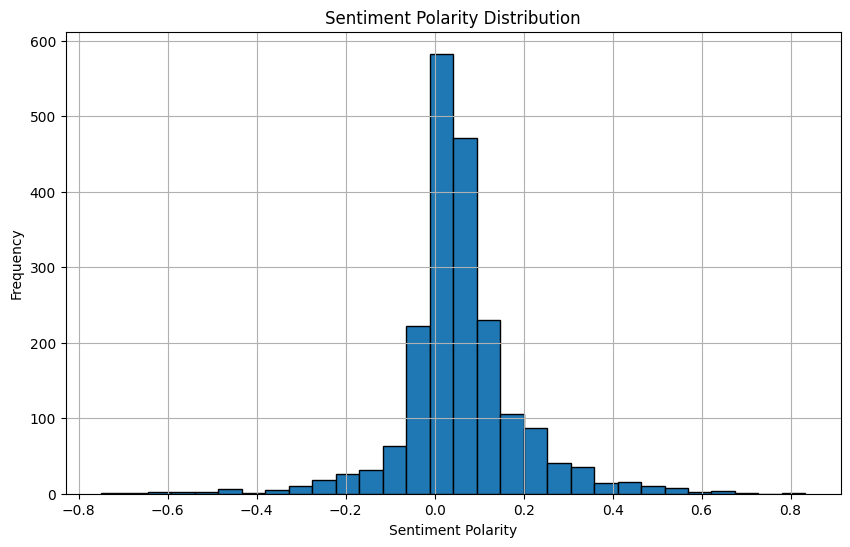

In [12]:
# Plot sentiment distribution: Visualize the distribution of sentiment polarity
# Create a figure with a specified size (10x6 inches)
plt.figure(figsize=(10, 6))
# Plot a histogram of the 'Overall_Sentiment' column with 30 bins, and black edges around the bars
reddit_data['Overall_Sentiment'].hist(bins=30, edgecolor='black')
# Set the title of the plot
plt.title("Sentiment Polarity Distribution")
# Label the x-axis
plt.xlabel("Sentiment Polarity")
# Label the y-axis
plt.ylabel("Frequency")
# Display the plot
plt.show()

In [13]:
# Summary of data: Generate key statistics and metrics for the dataset and model evaluation
# Print the total number of posts scraped from Reddit
print(f"Number of Posts Scraped: {len(reddit_data)}")
# Print the average sentiment across all posts
print(f"Average Sentiment: {reddit_data['Overall_Sentiment'].mean()}")
# Count and print the number of posts with positive sentiment
print(f"Number of Positive Sentiments: {(reddit_data['Overall_Sentiment'] > 0).sum()}")
# Count and print the number of posts with negative sentiment
print(f"Number of Negative Sentiments: {(reddit_data['Overall_Sentiment'] < 0).sum()}")
# Calculate and print the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)  # Recalculate the accuracy (in case it's needed after changes)
print("Accuracy:", accuracy)

Number of Posts Scraped: 1997
Average Sentiment: 0.05731442205549408
Number of Positive Sentiments: 1496
Number of Negative Sentiments: 460
Accuracy: 0.9975
